## Project Overview

This project analyzes a network of Wikipedia editors and their interactions through article reverts. Using Romanian Wikipedia editing data from 2006, we construct a directed network where nodes represent editors and edges represent revert actions between them.

The analysis focuses on three main aspects:
1. Building a network of "who reverted whom" to understand the relationship dynamics between editors
2. Identifying patterns of reciprocal reverts (when editor A reverts editor B, and then B reverts A within 24 hours)
3. Examining the role of editor seniority in revert behaviors, particularly whether editors of similar experience levels are more likely to engage in revert conflicts

The implementation prioritizes computational efficiency through carefully optimized data structures and algorithms, including custom parsing functions, binary search for temporal lookups, and memory management techniques to handle large datasets.

Python packages are generated for modular code implementations in processing and analysis.


### Data

We will use data from the file `../data/rowiki_2006.txt` in the `data` repository on GitHub. 
To data were originally obtained from the Wikipedia XML Dumps (https://dumps.wikimedia.org/mirrors.html) and include every article edit made on Romanian Wikipedia since it began until the end of 2006. Each line in the file is an edit and includes the title of the edited article, the time when the edit was submitted, whether the edit was a revert, the version of the article, and the user who submitted the edit. To detect the article versions, a hash was calculated for the complete article text following each revision and the hashes were compared between edits. 

The table below describes the variables in the data:

| Variable   | Explanation   
|:-----------|:-------
| title      | title of the edited article               
| time       | time in the format YYYY-MM-DD HH:MM:SS when the edit was completed  
| revert     | 1 if the edit was detected to revert to a previous article version, 0 otherwise 
| version    | an integer indicating a unique state of the article, generally increasing over time; -1 indicates the article was empty (usually due to vandalism); if the same number appears more than once, then the article was exactly in the same state at these different time points  
| user       | the editor's username or if not logged in, the editor's IP address  


### 1. Who reverted whom?

We will estimate seniority $s_i$ of editor $i$ as the base-ten logarithm of the number of edits $i$ has completed by the time of the revert under question. Transforming the number of edits with the logarithm makes sense because they follow a power-law distribution (the majority of individuals have very few edits, while a handful of individuals are responsible for most of the work). This operationalization allows to express the difference in seniority between two editors as the base-ten logarithm of the ratio of number of edits since $s_i - s_j = \log_{10} e_i - \log_{10} e_j = \log_{10} \frac{e_i}{e_j}$, where $e_i$ is the number of edits of editor $i$ and $e_j$ is the number of edits of editor $j$. In essence, we assume that an editor who has 10 edits compares to one with 100 edits the same way that an editor with 1,000 edits compares to one with 10,000.

In [31]:
import math
from datetime import datetime
from edge_processing import find_seniority
from data_processing import parse_date

# 1) Load data as list of dictionaries

# Obtain revert network data
wiki_data = []
# Open the file and turn into a list of dictionaries
with open('../data/rowiki_2006.txt', 'r') as file:
    columns = file.readline().strip().split('\t')
    for line in file:
        values = line.strip().split('\t')
        row_data = {columns[i]: values[i] for i in range(len(columns))}
        wiki_data.append(row_data)

# Convert the 'time' field to datetime
for row in wiki_data:
    # Use custom function instead of datetime.strptime because it is faster
    row['time'] = parse_date(row['time'])

# 2) Find cumulative edits by the user for each edit
    
# Copy wiki data, sort copy by time, group by user, utilized as look-up table in later seniority calculation 
wiki_user_sort = wiki_data.copy()
wiki_user_sort.sort(key = lambda x: (x['user'], x['time']))

# Store counters for next section
total_edits = 0
user_edits_dict = {}
user_data = []
prev_user = None

# Iterate over edits sorted in order of user and time in order to:
# a) find cumulative edits
# b) store each's user's total edits in a dictionary, used as a look-up table in the next section
for row in wiki_user_sort:
    # If new user:
    if row['user'] != prev_user:
        # Handle first row
        if prev_user is not None:
            user_edits_dict[prev_user] = user_data
        # Reset cumulative edits
        total_edits = 1
        # Reset user data record
        user_data = []
        # Update previous user
        prev_user = row['user']
    # If same user, increment cumulative edits
    else:
        total_edits += 1
    # Add cumulative edits to row
    row['cum_edits'] = total_edits
    # Store user edit data in dictionary with key = user, value = list of dictionaries (where index increases with time)
    user_data.append({'time': row['time'], 'cum_edits': total_edits})

# Adding the last user's data
if prev_user is not None:
    user_edits_dict[prev_user] = user_data

# 3) Create edge list

# Sort edits list by time and group by title
# This ordering will be used as a lookup table in the next step, where index is used to chronologically iterate over user edits
wiki_data.sort(key=lambda x: (x['title'], x['time']))

# Generate a simplified list of revert and version numbers to speed up row iteration 
revert_version_list = [[int(row['revert']), int(row['version'])] for row in wiki_data]

edge_list = []
# Keep track of visited edits to perform backwards search
visited = []
edge_list = []

#Iterate over the revert_version_list and find the reverter:reverted pairings, and add reverter seniority
for index, row in enumerate(revert_version_list):
    # Check if row is a revert
    if row[0] == 0:
        # If not, then add to visited, and move on
        visited.append(row)
        continue
    # For rows that are reverts:
    else:
        # Reverter index is index of current row
        reverter_index = index
        # Track distance between current index and index of reverted user (reverted_index) - initialize to 0
        distance = 0 
        # Iterate over the visited edits starting from the most recent
        for visited_row in visited[::-1]:
            # Increment distance
            distance += 1
            # Check if version matches version of the revert, if so
            if visited_row[1] == row[1]:
                # Record the index of the reverted as one index closer than the distance to the reverted version
                reverted_index = reverter_index - distance + 1
                break
        # Add the row to the visited list, maintains accuracy of the distance measure
        visited.append(row)
        # Check if it is an 'edit but no change'
        if reverter_index == reverted_index:
            continue
        # Check if it is 'self-revert'
        elif wiki_data[reverter_index]['user'] == wiki_data[reverted_index]['user']:
            continue
        else:
        # If it is a true revert, append to list in dictionary format, leave a placeholder for reverted_seniority
            edge_list.append({'reverter': wiki_data[reverter_index]['user'], 'reverted': wiki_data[reverted_index]['user'], 
                                'time': wiki_data[reverter_index]['time'], 'reverter_seniority': math.log10(wiki_data[reverter_index]['cum_edits']),
                                'reverted_seniority': 0}) 
            
    # For every true revert, check if the title has changed in the last 20 iterations, if so, reduce visited list size (saves memory)
    if wiki_data[index-20]['title'] != wiki_data[index]['title']:
        # Keep only previous 20 visited edits, which is sufficient to not miss any reverts
        visited = visited[-20:]

# 4) To complete the edge list data, add reverted seniority

# Sort edge_list by reverted user, to speed up processing, iterate through users in batches
edge_list.sort(key=lambda x: x['reverted'])

# Initialize user and user data list
user = edge_list[0]['reverted']
current_user_data_list = user_edits_dict[user]

# Iterate through all edges in the edge_list and update 'reverted_seniority'
for row in edge_list:
    # Check if current reverted user has changed
    if row['reverted'] != user:
        # If so, update user and user data list
        user = row['reverted']
        current_user_data_list = user_edits_dict[user]
    # Find seniority of reverted user using custom function that utilizes binary search
    row['reverted_seniority'] = find_seniority(row['time'], current_user_data_list)

# 5) Compute summary statistics

# Calculate the total nodes in the network (i.e. unique reverters or reverted users)
nodes = []
for edge in edge_list:
    nodes.append(edge['reverter'])
    nodes.append(edge['reverted'])
nodes = set(nodes)
    
# Print the first 5 edges points in the network
print("First 5 edge rows:", edge_list[:5])

# Print the number of nodes and edges in the network
print('Number of nodes: ', len(nodes))
print('Number of edges: ', len(edge_list))

First 5 edge rows: [{'reverter': 'Orioane', 'reverted': '*onika*', 'time': datetime.datetime(2006, 11, 23, 8, 51, 12), 'reverter_seniority': 3.527887565952705, 'reverted_seniority': 0.0}, {'reverter': 'Iulianu', 'reverted': '.Vlad', 'time': datetime.datetime(2006, 1, 9, 10, 50, 34), 'reverter_seniority': 3.3988077302032647, 'reverted_seniority': 0.0}, {'reverter': 'Vlad', 'reverted': '10.0.0.8', 'time': datetime.datetime(2005, 10, 11, 16, 56, 2), 'reverter_seniority': 3.512550992904211, 'reverted_seniority': 0.0}, {'reverter': 'AdiJapan', 'reverted': '12.32.83.4', 'time': datetime.datetime(2006, 3, 3, 10, 46, 39), 'reverter_seniority': 3.164352855784437, 'reverted_seniority': 0.6020599913279624}, {'reverter': 'Vlad', 'reverted': '12.32.83.4', 'time': datetime.datetime(2006, 3, 10, 23, 36, 28), 'reverter_seniority': 3.874191804679071, 'reverted_seniority': 0.6989700043360189}]
Number of nodes:  4805
Number of edges:  7362


### 2. If $A$ reverted $B$, did $B$ revert $A$?

Identify the two-event sequence in which after $A$ reverts $B$, $B$ reverts $A$ back ($AB–BA$) within 24 hours. To identify these sequences, we will use the revert data from the previous task. We will ignore the article titles — we are agnostic as to whether the response happens in the same or in different articles. Further, it does not matter whether the response occurs immediately after the original revert or alternatively, the reverter and the reverted are involved in other reverts in-between the original revert and the response. If more than one response occurs within 24 hours, we will consider only the first one as part of the event sequence.

In [32]:
from edge_analysis import get_ab_ba_sequences

# Use function to get AB-BA sequences, stored in a list of lists of dictionaries - [AB-row, BA-row]
ab_ba_sequences = get_ab_ba_sequences(edge_list)

# Print the number of AB-BA sequences
print("Number of AB-BA event sequences:", len(ab_ba_sequences))

Number of AB-BA event sequences: 320


### 3. Are $A$ and $B$ more similar in seniority than expected?

Social comparison theory states that people strive to gain accurate self-evaluations and as a result, they tend to compare themselves to those who are similar. But since focus on relative performance heightens feelings of competitiveness, rivalry is stronger among similar individuals. This leads us to expect that the editors involved in the $AB–BA$ event sequences tend to be closer in seniority than expected.

We will compare  *absolute difference* in seniority between editors involved in $AB–BA$ event sequences with the absolute difference in seniority between editors involved in any other revert (all the reverts in the data that are not part of the AB–BA sequences).


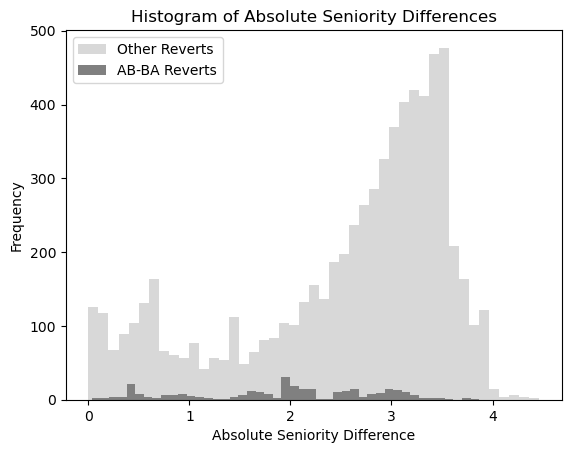

Mean Absolute Seniority Difference in AB-BA Reverts: 1.9298075651514288
Mean Absolute Seniority Difference in Other Reverts: 2.5336849279182605


In [33]:
import matplotlib.pyplot as plt

# Store absolute seniority difference for reverts in AB-BA sequences and the rest
ab_ba_seniority_diff = []
other_reverts_seniority_diff = []

# Note we're using the seniority measures recorded at time of BA revert, but using the AB version wouldn't make a significant difference

# Extracting seniority differences for AB-BA sequences
# Iterate over all AB-BA revert pairs
for sequence in ab_ba_sequences:
    # Get the BA revert data
    ba_row = sequence[1]
    a_seniority = ba_row['reverter_seniority']
    b_seniority = ba_row['reverted_seniority']
    # Store the absolute difference
    ab_ba_seniority_diff.append(abs(b_seniority - a_seniority))

# Flatten ab_ba_sequences to improve efficiency of next step
ab_ba_sequences = [item for sublist in ab_ba_sequences for item in sublist]

# Extracting seniority differences for all other reverts
for edge in edge_list:
    # Check if edge is in ab_ba_sequences
    if edge not in ab_ba_sequences:
        reverter_seniority = edge['reverter_seniority']
        reverted_seniority = edge['reverted_seniority']
        other_reverts_seniority_diff.append(abs(reverter_seniority - reverted_seniority))

# Plot a histogram with the two distributions overlapping
plt.hist(other_reverts_seniority_diff, bins=45, alpha=0.3, color = 'grey', label='Other Reverts')
plt.hist(ab_ba_seniority_diff, bins=45, alpha=1, color= 'grey', label='AB-BA Reverts')
plt.xlabel('Absolute Seniority Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Absolute Seniority Differences')
plt.legend()
plt.show()

# Print the mean abs. seniority diff. for reverts in AB-BA sequences and the rest
mean_ab_ba_diff = sum(ab_ba_seniority_diff) / len(ab_ba_seniority_diff)
mean_other_diff = sum(other_reverts_seniority_diff) / len(other_reverts_seniority_diff)

print("Mean Absolute Seniority Difference in AB-BA Reverts:", mean_ab_ba_diff)
print("Mean Absolute Seniority Difference in Other Reverts:", mean_other_diff)

